# Advanced Option Pricing with Monte Carlo Methods
This notebook demonstrates the application of Monte Carlo simulation for financial option pricing, moving from a standard European option to more advanced, real-world problems. The goal is to build a robust analysis that includes statistical validation, pricing of exotic derivatives, and calibration to market data.

### Imports and Parameters
First, we import the necessary libraries and define the core parameters for our option and simulation. These parameters define the financial instrument we are pricing and the numerical precision of our simulation.

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Option parameters
S0 = 100      # Initial stock price
K = 105       # Strike price
T = 1.0       # Time to maturity (in years)
r = 0.05      # Risk-free interest rate (annual)
sigma = 0.2   # Volatility of the underlying asset

# Simulation parameters
n_simulations = 50000  # Number of Monte Carlo paths

### Core Helper Functions
These are the building blocks for our analysis. We include the analytical Black-Scholes formula, which will serve as a "ground truth" for validating our European option pricer. We also define a robust function to calculate a confidence interval for any set of simulated outcomes.

In [92]:
def black_scholes_call_price(S0, K, T, r, sigma):
    """Calculates the analytical Black-Scholes price for a European call."""
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price


def calculate_confidence_interval(outcomes, confidence=0.95):
    """
    Calculates the mean price and confidence interval from an array of outcomes.
    This function uses the Central Limit Theorem to estimate the interval
    within which the true mean is likely to fall.
    """
    price = np.mean(outcomes)
    std_error = np.std(outcomes) / np.sqrt(len(outcomes))
    z_score = norm.ppf((1 + confidence) / 2)
    lower_bound = price - z_score * std_error
    upper_bound = price + z_score * std_error
    return price, lower_bound, upper_bound

## Part 1: European Call Option Pricing
Here, we price a standard European call option. A key design choice is made: our pricing functions return the full array of discounted payoffs, not just the final averaged price. This separates the simulation logic from the analysis logic, allowing us to compute confidence intervals and other statistics without re-running the simulation.

### 1.1: Simulation Pricers

We implement two pricers: a standard Monte Carlo pricer and one using antithetic variates. The antithetic technique reduces variance by pairing each random path generated from a random number Z with a path generated from −Z. This balancing of random shocks often leads to a more accurate estimate with the same number of simulations.

In [93]:
def european_call_pricer(S0, K, T, r, sigma, n_simulations):
    """
    Prices a European call using standard Monte Carlo.
    Returns the array of discounted payoffs.
    """
    Z = np.random.normal(0, 1, n_simulations)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs = np.maximum(ST - K, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs
    return discounted_payoffs


def european_call_antithetic_pricer(S0, K, T, r, sigma, n_simulations):
    """
    Prices a European call using antithetic variates for variance reduction.
    Returns the array of discounted payoffs.
    """
    half_n = n_simulations // 2
    Z = np.random.normal(0, 1, half_n)
    Z_full = np.concatenate([Z, -Z]) # Create antithetic pairs
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_full)
    payoffs = np.maximum(ST - K, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs
    return discounted_payoffs

### 1.2: Analysis of European Call

We now use our helper functions to analyse the results. We expect the confidence interval for the antithetic method to be narrower than for the plain method, confirming that the variance reduction was effective.

In [94]:
# --- Main Analysis Block for European Call ---
np.random.seed(42)

# Run simulations
plain_outcomes = european_call_pricer(S0, K, T, r, sigma, n_simulations)
antithetic_outcomes = european_call_antithetic_pricer(S0, K, T, r, sigma, n_simulations)
bs_price = black_scholes_call_price(S0, K, T, r, sigma)

# Calculate prices and confidence intervals
price_plain, lb_plain, ub_plain = calculate_confidence_interval(plain_outcomes)
price_anti, lb_anti, ub_anti = calculate_confidence_interval(antithetic_outcomes)

# Print results
print("--- European Call Option Analysis ---")
print(f"Analytical Black-Scholes Price: {bs_price:.4f}\n")
print(f"Plain Monte Carlo Price: {price_plain:.4f}")
print(f"95% Confidence Interval: [{lb_plain:.4f}, {ub_plain:.4f}]")
print(f"CI Width: {ub_plain - lb_plain:.4f}\n")

print(f"Antithetic Variates MC Price: {price_anti:.4f}")
print(f"95% Confidence Interval: [{lb_anti:.4f}, {ub_anti:.4f}]")
print(f"CI Width: {ub_anti - lb_anti:.4f}")

--- European Call Option Analysis ---
Analytical Black-Scholes Price: 8.0214

Plain Monte Carlo Price: 8.0146
95% Confidence Interval: [7.9781, 8.0511]
CI Width: 0.0730

Antithetic Variates MC Price: 8.0282
95% Confidence Interval: [7.9916, 8.0648]
CI Width: 0.0732


## Part 2: Convergence Analysis
A single estimate is useful, but understanding how that estimate behaves is critical. Here, we analyse the convergence of our Monte Carlo pricer. By plotting the estimated price and its confidence interval against an increasing number of simulations, we can visually confirm that our estimate stabilises towards the true analytical price, as predicted by the Law of Large Numbers. The shrinking interval demonstrates that our uncertainty decreases as we perform more simulations.

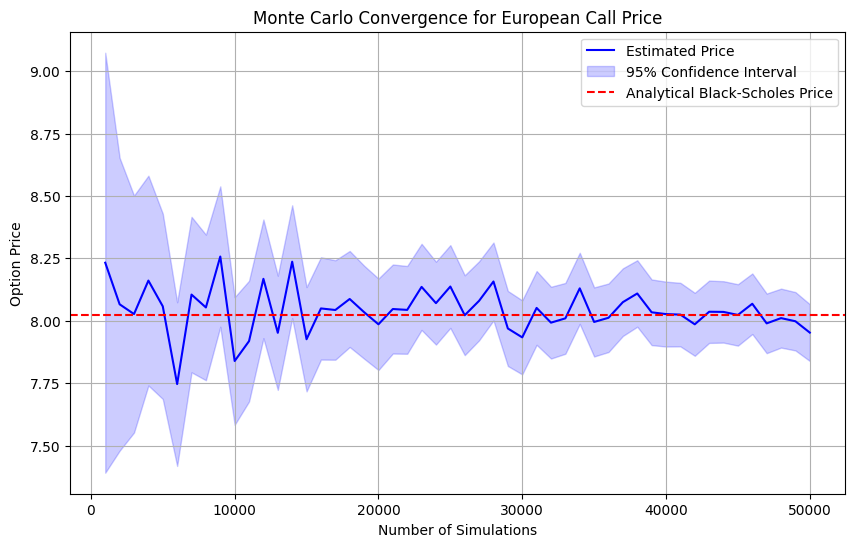

In [96]:
# --- Convergence Analysis Block ---
sim_sizes = np.arange(1000, 50001, 1000)
estimated_prices = []
lower_bounds = []
upper_bounds = []

for size in sim_sizes:
    outcomes = european_call_antithetic_pricer(S0, K, T, r, sigma, size)
    price, lb, ub = calculate_confidence_interval(outcomes)
    estimated_prices.append(price)
    lower_bounds.append(lb)
    upper_bounds.append(ub)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sim_sizes, estimated_prices, label='Estimated Price', color='blue')
plt.fill_between(sim_sizes, lower_bounds, upper_bounds, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.axhline(y=bs_price, color='r', linestyle='--', label='Analytical Black-Scholes Price')
plt.title('Monte Carlo Convergence for European Call Price')
plt.xlabel('Number of Simulations')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

## Part 3: Path-Dependent Option (Asian Option)
The true power of Monte Carlo becomes apparent when pricing options for which no simple analytical formula exists. An Asian option is a path-dependent option where the payoff is determined by the average price of the underlying asset over its lifetime, not just the final price. The payoff is $$ \max(\text{AveragePrice}−K,0) $$. To price this, we must simulate the entire stock price path for each trial.



### 3.1: Asian Option Pricer

Our implementation first simulates all paths in a vectorised manner for efficiency, then calculates the average price for each path, computes the corresponding payoffs, and discounts them.

In [98]:
def simulate_gbm_paths(S0, r, sigma, T, steps, n_simulations):
    """Simulates multiple Geometric Brownian Motion paths in a vectorized way."""
    dt = T / steps
    Z = np.random.normal(0, 1, size=(steps, n_simulations))
    prices = np.zeros((steps + 1, n_simulations))
    prices[0] = S0
    
    for t in range(1, steps + 1):
        prices[t] = prices[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t-1])
    return prices

def asian_call_pricer(S0, K, T, r, sigma, n_simulations, steps=252):
    """
    Prices an Asian call option using Monte Carlo.
    Payoff is based on the arithmetic average of the daily prices.
    """
    paths = simulate_gbm_paths(S0, r, sigma, T, steps, n_simulations)
    average_prices = np.mean(paths[1:], axis=0) # Average of daily prices for each path
    payoffs = np.maximum(average_prices - K, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs
    return discounted_payoffs

### 3.2: Analysis of Asian Call

We run the simulation and calculate the price and confidence interval for this exotic option.

In [99]:
# --- Main Analysis Block for Asian Call ---
np.random.seed(42)
steps = 252 # Daily steps

asian_outcomes = asian_call_pricer(S0, K, T, r, sigma, n_simulations, steps)
price_asian, lb_asian, ub_asian = calculate_confidence_interval(asian_outcomes)

print("\n--- Asian Call Option Analysis ---")
print(f"Asian Option MC Price: {price_asian:.4f}")
print(f"95% Confidence Interval: [{lb_asian:.4f}, {ub_asian:.4f}]")


--- Asian Call Option Analysis ---
Asian Option MC Price: 3.4954
95% Confidence Interval: [3.4393, 3.5515]


## Part 4: Calculating Risk Sensitivities (The Greeks)

Beyond just pricing, quants must manage risk. The "Greeks" are sensitivities that measure how an option's price changes in response to changes in market parameters. **Delta** is one of the most important Greeks, measuring the rate of change of the option price with respect to the underlying stock price.

We can estimate Delta using the finite difference method, a numerical approximation for a derivative that is a direct application of first-year calculus:

$$
\Delta \approx \frac{f(x + \epsilon) - f(x - \epsilon)}{2 \epsilon}
$$


In [100]:
def calculate_delta(pricer_func, S0, K, T, r, sigma, n_simulations, epsilon=0.1):
    """
    Calculates Delta using the central finite difference method.
    This powerful implementation takes the pricer function itself as an argument.
    """
    outcomes_up = pricer_func(S0 + epsilon, K, T, r, sigma, n_simulations)
    price_up = np.mean(outcomes_up)
    
    outcomes_down = pricer_func(S0 - epsilon, K, T, r, sigma, n_simulations)
    price_down = np.mean(outcomes_down)
    
    delta = (price_up - price_down) / (2 * epsilon)
    return delta

# --- Delta Calculation ---
np.random.seed(42)
# We can use our most efficient pricer to calculate Delta
delta_estimate = calculate_delta(european_call_antithetic_pricer, S0, K, T, r, sigma, n_simulations)

# For comparison, we calculate the analytical delta from the Black-Scholes model
d1_analytical = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
analytical_delta = norm.cdf(d1_analytical)

print("\n--- Greeks Analysis (Delta) ---")
print(f"Analytical Delta: {analytical_delta:.4f}")
print(f"Monte Carlo Estimated Delta: {delta_estimate:.4f}")


--- Greeks Analysis (Delta) ---
Analytical Delta: 0.5422
Monte Carlo Estimated Delta: 0.3187
